In [1]:
from sklearn.datasets import make_circles
import pandas as pd 
import matplotlib.pyplot as plt 
import torch 
from torch import nn
import numpy as np

In [2]:


train , target = make_circles(n_samples=1000)
train_df = pd.DataFrame(train , columns=[f'feature{i}' for i in range(train.shape[1])])
target_df = pd.DataFrame(target , columns=['target'])

df = pd.concat([train_df , target_df] , axis=1)
df.head()

,feature0,feature1,target
0,0.747463,0.285130,1
1,0.420140,0.680796,1
2,-0.562120,0.569229,1
3,0.763892,-0.237633,1
4,0.478324,-0.641254,1


In [3]:
from sklearn.model_selection import train_test_split 
xtrain , xtest , ytrain, ytest = train_test_split(train, target , test_size=0.2)
xtrain.shape , xtest.shape , ytrain.shape , ytest.shape


((800, 2), (200, 2), (800,), (200,))

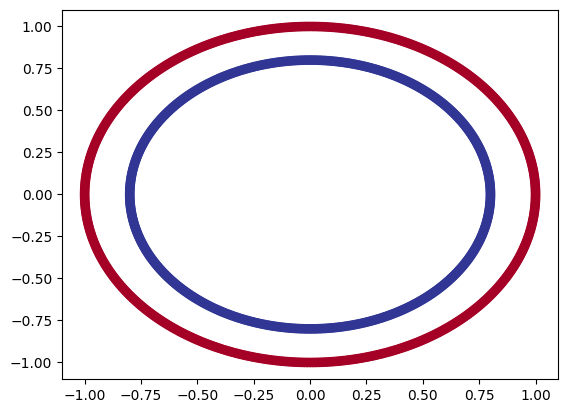

In [4]:
plt.scatter(train[:, 0] , train[:, 1] , c=target , cmap=plt.cm.RdYlBu)

In [5]:
train = torch.from_numpy(train).type(torch.float32)
target = torch.from_numpy(target).type(torch.float32)

In [91]:
class CircleModel(nn.Module): 
    def __init__(self): 
        super().__init__() 
        self.layer1 = nn.Linear(in_features=2 , out_features=8)
        self.layer2 = nn.Linear(in_features=8 , out_features=4)
        self.layer4 = nn.Linear(in_features=4 , out_features=1)

    def forward(self , x:torch.tensor)->torch.tensor: 
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer4(x)
        return x
    

model = CircleModel() 

In [7]:
next(model.parameters()).device

device(type='cpu')

In [95]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model.parameters() , lr=0.1)

In [ ]:
def measure_metrics(ypred, ytrue):
    from sklearn.metrics import accuracy_score, f1_score, recall_score
    return {
        "accuracy": accuracy_score(ytrue, ypred),
        "f1": f1_score(ytrue, ypred),
        "recall": recall_score(ytrue, ypred),
    }


In [22]:
def convert_to_tensor(array): 
    return torch.from_numpy(array).type(torch.float)

In [135]:
epochs = 50

for epoch in range(epochs): 
        model.train() 
        ypred = model(convert_to_tensor(xtrain)).squeeze()
        loss = loss_fn(ypred , convert_to_tensor(ytrain))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  

In [ ]:
# ypred = torch.round(torch.sigmoid(ylogits))

# accuracy, f1, recall = measure_metrics(
#         ypred.detach().cpu().numpy(),
#         torch.tensor(ytrain).detach().cpu().numpy()
#     )